# Outline: Representation and Selection of Descriptors
1. Description of typical descriptors and libraries for handling biomolecules
	a. Molecular fingerprints (e.g., ECFP, MACCS keys) 
	b. Learned representations (e.g., learned embeddings from molecular strings {SMILES, SELFIES, SMARTS patterns for structural fragments}, 2D graphs).
	c. Atomic-centered descriptors
		i. SOAP
	d. Coulomb matrices (where to put, exactly?)
	e. Physicochemical properties (e.g., molecular weight, logP, perhaps just go over the ones in QM7)

2. Typical data preprocessing steps
	a. Handling data on different scales (normalization and scaling techniques, standardization {e.g., z-score normalization}, min-max scaling, robust scaling 

3. Feature selection
	a.Illustrate with 2D representation, 3D representation, and MD trajectories (3 examples of increasing complexity).

# Description of typical descriptors and libraries for handling biomolecules 
Molecules are complex and can be represented by strings (e.g., SMILES), 2D graphs, and conformers. There are a few libraries for working with molecule "objects" in Python, one of the most popular being [RDKit](https://www.rdkit.org/), which we will also use in this notebook. For a nice tutorial on using RDKit, we encourage you to check out Pat Walter's [A Whirlwind Introduction to RDKit](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/fundamentals/A_Whirlwind_Introduction_To_The_RDKit.ipynb#scrollTo=hYYXfRSHLdTA).

To import the necessary libraries for this tutorial, run the following cell:

In [1]:
from rdkit import Chem       # description
from rdkit.Chem import Draw  # used for drawing molecules
import numpy as np
import scipy.io
import xyz2mol as xyz2mol

We can begin analyzing molecules by looking at the molecules in QM7. The QM7 dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules. It contains the Coulomb matrix representation of these molecules and their atomization energies computed similarly to the FHI-AIMS implementation of the Perdew-Burke-Ernzerhof hybrid functional (PBE0). This dataset features a large variety of molecular structures such as double and triple bonds, cycles, carboxy, cyanide, amide, alcohol and epoxy.

To download and load the QM7 dataset as a Python dictionary, run:

In [2]:
!wget http://quantum-machine.org/data/qm7.mat
!mv qm7.mat ../data/.

raw_qm7 = scipy.io.loadmat("../data/qm7.mat") # the qm7 dataset will be loaded as a Python dictionary

--2023-07-06 16:24:35--  http://quantum-machine.org/data/qm7.mat
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17884280 (17M)
Saving to: ‘qm7.mat’

qm7.mat             100%[===================>]  17,06M  16,7MB/s    in 1,0s    

2023-07-06 16:24:37 (16,7 MB/s) - ‘qm7.mat’ saved [17884280/17884280]



The dataset is composed of five multidimensional arrays:
- X (7165 x 23 x 23) - Coulomb matrices
- T (7165) - atomization energies (the labels)
- P (5 x 1433) - cross-validation splits
- Z (7165) - atomic charge of each atom in the molecules
- R (7165 x 3) - Cartesian coordinates of each atom in the molecules

In [4]:
X = raw_qm7["X"] # Coulomb matrices
T = raw_qm7["T"] # atomization energies
P = raw_qm7["P"] # cross-validation splits
Z = raw_qm7["Z"] # atomic numbers
R = raw_qm7["R"] # coordinates

To make it a bit easier to work with the molecules, let's convert them into RDKit ´Mol´ objects, and respectively into the corresponding SMILES:

In [126]:
# # Get the molobjs
# atoms       = Z
# coordinates = R
#
# mols   = []
# smiles = []
# for idx, atom in enumerate(atoms):
#     mol = xyz2mol.xyz2mol(atom, coordinates[idx], allow_charged_fragments=False)
#     mols.append(mol)
#     smiles.append(Chem.MolToSmiles(mol))

smiles = open("../4-Autoencoders/smiles.txt").read().split()
mols   = [Chem.MolFromSmiles(smi) for smi in smiles]

[11:04:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 2 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 2 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 2 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[11:04:17] Explicit valence for atom # 3 N, 4, is g

Let's look at some of the SMILES from QM7:

methane: C


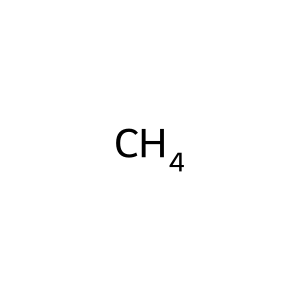

2-aminoacetaldehyde: CNCC=O


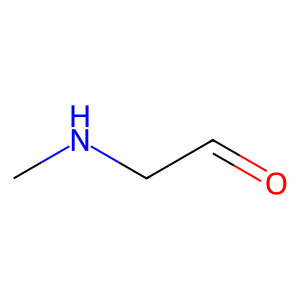

1-methylcyclopropan-1-ol: CC1(O)CC1


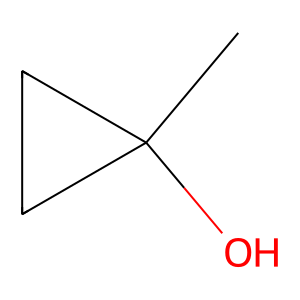

In [137]:
from IPython.display import display

print("methane:", smiles[0])
methane_img       = Draw.MolToImage(mols[0])
display(methane_img)

print("2-aminoacetaldehyde:", smiles[100])
aminoacetaldehyde_img = Draw.MolToImage(mols[100])
display(aminoacetaldehyde_img)

print("1-methylcyclopropan-1-ol:", smiles[200])
methylcyclopropanol_img       = Draw.MolToImage(mols[200])
display(methylcyclopropanol_img)

## Molecular Fingerprints
### Morgan Fingerprints
Now that we have our list of molecules, we can represent them using one of the most common representations used in cheminformatics: [Morgan fingerprints](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf). Fingerprints can have different, user-defined lengths. Here, we will generate radius 2 Morgan fingerprints for the above three molecules using bit lengths of 256, 512, and 1048:

In [163]:
# 256-bit
methane_bitInfo_256fp             = {}
aminoacetaldehyde_bitInfo_256fp   = {}
methylcyclopropanol_bitInfo_256fp = {}
methane_256fp             = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[0], useChirality=True, radius=2, nBits=256, bitInfo=methane_bitInfo_256fp)
aminoacetaldehyde_256fp   = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[100], useChirality=True, radius=2, nBits=256, bitInfo=aminoacetaldehyde_bitInfo_256fp)
methylcyclopropanol_256fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[200], useChirality=True, radius=2, nBits=256, bitInfo=methylcyclopropanol_bitInfo_256fp)

# 512-bit
methane_512fp             = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[0], useChirality=True, radius=2, nBits=512)
aminoacetaldehyde_512fp   = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[100], useChirality=True, radius=2, nBits=512)
methylcyclopropanol_512fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[200], useChirality=True, radius=2, nBits=512)

# 1048-bit
methane_1048fp             = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[0], useChirality=True, radius=2, nBits=1048)
aminoacetaldehyde_1048fp   = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[100], useChirality=True, radius=2, nBits=1048)
methylcyclopropanol_1048fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[200], useChirality=True, radius=2, nBits=1048)

Let's visualize the different fingerprints using black squares to indicate nonzero bits and gray squares to indicate zero bits:

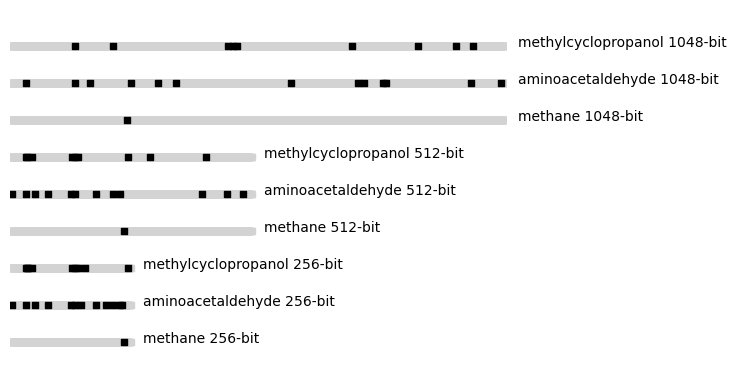

In [140]:

import matplotlib.pyplot as plt

def plot_fingerprint(fp, label, offset=0, factor=0.1):
    fp = np.array(fp)
    active_bits = np.where(fp == 0.0)[0]
    x = active_bits
    y = fp[active_bits] * 0 + factor * offset
    plt.scatter(x, y, color="lightgray", s=25, marker="s")
    active_bits = np.where(fp == 1.0)[0]
    x = active_bits
    y = fp[active_bits] * 0 + factor * offset
    plt.scatter(x, y, color="black", s=25, marker="s")
    plt.text(len(fp)+25, factor * offset, label)


# 256-bit
plot_fingerprint(fp=methane_256fp, label="methane 256-bit", offset=0)
plot_fingerprint(fp=aminoacetaldehyde_256fp, label="aminoacetaldehyde 256-bit", offset=1)
plot_fingerprint(fp=methylcyclopropanol_256fp, label="methylcyclopropanol 256-bit", offset=2)

# 512-bit
plot_fingerprint(fp=methane_512fp, label="methane 512-bit", offset=3)
plot_fingerprint(fp=aminoacetaldehyde_512fp, label="aminoacetaldehyde 512-bit", offset=4)
plot_fingerprint(fp=methylcyclopropanol_512fp, label="methylcyclopropanol 512-bit", offset=5)

# 1048-bit
plot_fingerprint(fp=methane_1048fp, label="methane 1048-bit", offset=6)
plot_fingerprint(fp=aminoacetaldehyde_1048fp, label="aminoacetaldehyde 1048-bit", offset=7)
plot_fingerprint(fp=methylcyclopropanol_1048fp, label="methylcyclopropanol 1048-bit", offset=8)

plt.xlim([0, 1048])
plt.ylim([-.1, 0.9])
plt.axis("off")

plt.show()

We can sketch out the parts of the structure contributing to the nonzero elemenbts of the fingerprints:

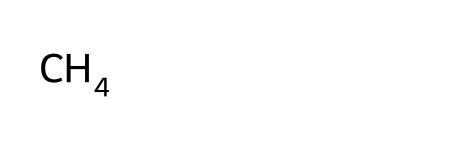

IndexError: tuple index out of range

In [165]:
methane_fp = np.array(methane_256fp)
bits_to_draw = []
for i in np.where(methane_fp == 1.0)[0]:
    for j in range(len(methane_bitInfo_256fp)):
        bits_to_draw.append((mols[0], i, methane_bitInfo_256fp, j))
methane_draw_fp = Draw.DrawMorganBits(bits_to_draw)
display(methane_draw_fp)

aminoacetaldehyde_fp = np.array(aminoacetaldehyde_256fp)
bits_to_draw = []
for i in np.where(aminoacetaldehyde_fp == 1.0)[0]:
    for j in range(len(aminoacetaldehyde_bitInfo_256fp)):
        bits_to_draw.append((mols[0], i, aminoacetaldehyde_bitInfo_256fp, j))
aminoacetaldehyde_draw_fp = Draw.DrawMorganBits(bits_to_draw)
display(aminoacetaldehyde_draw_fp)

methycyclopropanol_fp = np.array(methycyclopropanol_256fp)
bits_to_draw = []
for i in np.where(methycyclopropanol_fp == 1.0)[0]:
    for j in range(len(methycyclopropanol_bitInfo_256fp)):
        bits_to_draw.append((mols[0], i, methycyclopropanol_bitInfo_256fp, j))
methycyclopropanol_draw_fp = Draw.DrawMorganBits(bits_to_draw)
display(methycyclopropanol_draw_fp)

As you can see, most of the fingerprint bits are zero, and the larger you make the fingerprint, the sparser it usually gets (for small molecules). Most of the fingerprints are quite different for the three molecules.

[Move this somewhere else]: One of the challenges with this type of hash fingerprint is that you can get *bit collisions.* 

For comparison, let's look at the fingerprints of three similar molecules: methane, ethane, and ethene, and see how these fingerprints compare:

methane: C
ethane: CC
ethene: C=C


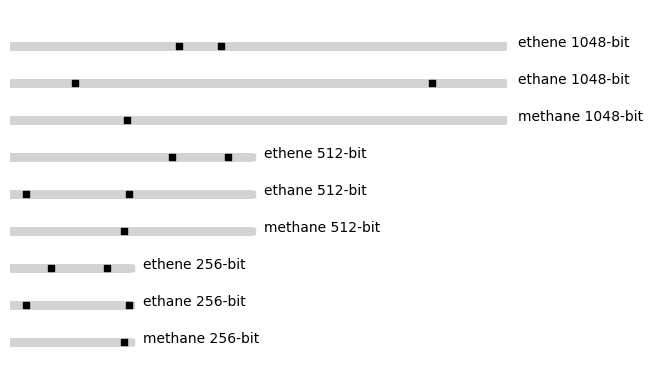

In [141]:
print("methane:", smiles[0])
print("ethane:",  smiles[1])
print("ethene:",  smiles[2])

# 256-bit
ethane_256fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[1], useChirality=True, radius=2, nBits=256)
ethene_256fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[2], useChirality=True, radius=2, nBits=256)

# 512-bit
ethane_512fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[1], useChirality=True, radius=2, nBits=512)
ethene_512fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[2], useChirality=True, radius=2, nBits=512)

# 1048-bit
ethane_1048fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[1], useChirality=True, radius=2, nBits=1048)
ethene_1048fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[2], useChirality=True, radius=2, nBits=1048)

# 256-bit
plot_fingerprint(fp=methane_256fp, label="methane 256-bit", offset=0)
plot_fingerprint(fp=ethane_256fp, label="ethane 256-bit", offset=1)
plot_fingerprint(fp=ethene_256fp, label="ethene 256-bit", offset=2)

# 512-bit
plot_fingerprint(fp=methane_512fp, label="methane 512-bit", offset=3)
plot_fingerprint(fp=ethane_512fp, label="ethane 512-bit", offset=4)
plot_fingerprint(fp=ethene_512fp, label="ethene 512-bit", offset=5)

# 1048-bit
plot_fingerprint(fp=methane_1048fp, label="methane 1048-bit", offset=6)
plot_fingerprint(fp=ethane_1048fp, label="ethane 1048-bit", offset=7)
plot_fingerprint(fp=ethene_1048fp, label="ethene 1048-bit", offset=8)

plt.xlim([0, 1048])
plt.ylim([-.1, 0.9])
plt.axis("off")

plt.show()

### Structural Keys
In structural keys, the structure of a molecule is encoded into a binary bit string (that is, a sequence of 0’s and 1’s), each bit of which corresponds to a “pre-defined” structural feature (e.g., substructure or fragment). If the molecule has a pre-defined feature, the bit position corresponding to this feature is set to 1. Otherwise, it is 0. It is important to understand that structural keys cannot encode structural features that are not pre-defined in the fragment library. In this example we will work with [MACCS keys](https://doi.org/10.1021/ci010132r). [PubChem Substructure Fingerprints](https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.pdf) are another example.

The MACCS (Molecular ACCess System) keys are one of the most commonly used structural keys. While there are two sets of MACCS keys (one with 960 keys and the other containing a subset of 166 keys), only the shorter fragment definitions are available to the public. These 166 public keys are implemented in popular open-source cheminformatics software packages, including RDKit.

Let's generate and visualize the MACCS keys using RDKit for the above molecules: methane, ethane, ethene, N-propylhydroxylamine, and butan-1-ol.

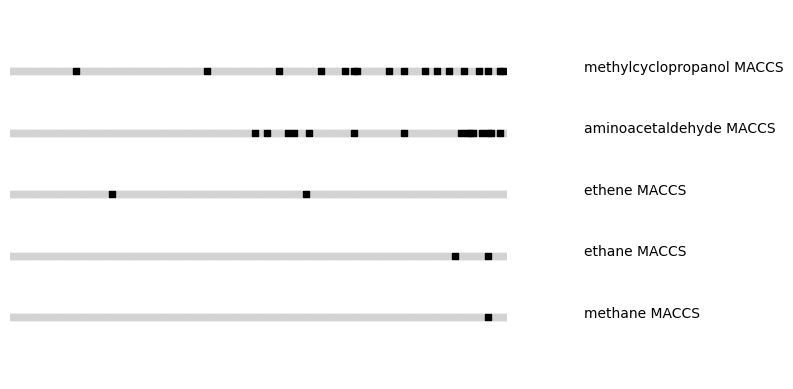

In [142]:
from rdkit.Chem import MACCSkeys

methane_maccs       = MACCSkeys.GenMACCSKeys(mols[0])
ethane_maccs        = MACCSkeys.GenMACCSKeys(mols[1])
ethene_maccs        = MACCSkeys.GenMACCSKeys(mols[2])
aminoacetaldehyde_maccs = MACCSkeys.GenMACCSKeys(mols[100])
methylcyclopropanol_maccs       = MACCSkeys.GenMACCSKeys(mols[200])

# plot the MACCS fingerprints
plot_fingerprint(fp=methane_maccs, label="methane MACCS", offset=0)
plot_fingerprint(fp=ethane_maccs, label="ethane MACCS", offset=1)
plot_fingerprint(fp=ethene_maccs, label="ethene MACCS", offset=2)
plot_fingerprint(fp=aminoacetaldehyde_maccs, label="aminoacetaldehyde MACCS", offset=3)
plot_fingerprint(fp=methylcyclopropanol_maccs, label="methylcyclopropanol MACCS", offset=4)

plt.xlim([0, 166])
plt.ylim([-.1, 0.5])
plt.axis("off")

plt.show()

### RDKit 2D Descriptor Fingerprints


[16:24:49] unsupported number of radical electrons 4


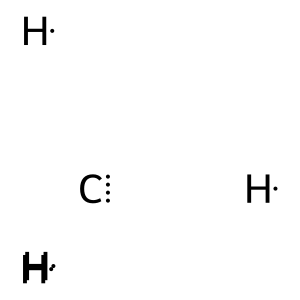

In [9]:
img = Draw.MolToImage(mols[0])
img


## Learned Representations

## Coulomb Matrices
Another way to represent molecular structures in cheminformatics is Coulomb matrices (CMs), where each element of the matrix captures the Coulombic interaction between pairs of atoms in a molecule, combining nuclear charge and interatomic distances. Below we show an example CM for water.

In [1]:
import numpy as np

# atomic numbers
Z_O = 8  # Oxygen
Z_H = 1  # Hydrogen

# distance between Oxygen and Hydrogen in Angstroms (approximate)
R_OH = 0.96

# Coulomb matrix for water (H2O)
# initialize the matrix
coulomb_matrix = np.zeros((3, 3))

# diagonal elements: 0.5 * Z^2.4
coulomb_matrix[0, 0] = 0.5 * Z_O ** 2.4  # Oxygen
coulomb_matrix[1, 1] = 0.5 * Z_H ** 2.4  # Hydrogen 1
coulomb_matrix[2, 2] = 0.5 * Z_H ** 2.4  # Hydrogen 2

# off-diagonal elements: Z_i * Z_j / R_ij
# assuming the distance between each hydrogen and the oxygen is the same
coulomb_matrix[0, 1] = coulomb_matrix[1, 0] = Z_O * Z_H / R_OH  # oxygen-hydrogen 1
coulomb_matrix[0, 2] = coulomb_matrix[2, 0] = Z_O * Z_H / R_OH  # oxygen-hydrogen 2
coulomb_matrix[1, 2] = coulomb_matrix[2, 1] = Z_H * Z_H / R_OH  # hydrogen-hydrogen

coulomb_matrix

array([[73.51669472,  8.33333333,  8.33333333],
       [ 8.33333333,  0.5       ,  1.04166667],
       [ 8.33333333,  1.04166667,  0.5       ]])

## Physicochemical Descriptors